<img src="https://static.dribbble.com/users/410907/screenshots/4531744/price_formation.gif"/>

# Определение цены товара
***
### Можем ли мы автоматически предлагать цену для нового товара или изменять её для пользователей?

От чего только не зависит цена на товар: сезонность, бренд, доступность на рынке и все-все-все другое, что не только входит в конкретный товар, а даже его "окружает".

Давайте погрузимся в мир ретейла и продаж, представим себе, что мы аналитики, которым поставили задачу построить такую модель, которая будет определять цену любого товара, который поступить. Но чтобы протестить вашу разработку, Ваша компания договорилась с платформой-"онлайн-барахолкой" для тестирования вашей модели. 

Платформа предложила свои исторические данные по тому, какую цену ставили пользователи, а также ваша компания "замешала" туда свои данные. У вас на руках данные, которые содержат: описание продукта, категории продукта, бренд и дополнительные детали. К несчастью (а может и нет), вы не знаете, где и какие данные.

Ваша задача состоит из двух основных шагов:
* **Сделать анализ данных**
* **Построить модель автоматического определения цены**

### Набор данных состоит из

- **ID**: id предмета
- **Name:** строка - наименование товара
- **Item Condition:** внутреннее условие (назначается поставщиком товара)
- **Category Name:** категория предмета
- **Brand Name:** бренд (если имеется)
- **Shipping:** доступна или нет доставка товара от поставщика
- **Item Description:** полное описание товара
- **Price:** фактическая цена за которую был продан товар (так как товар может торговаться по одной цене, а потом иметь скидки, тут указана цена именно продажи). В USD. Используем, как целевую переменную.

### Основные способы обработки данных в тексте
- **Удаление стоп слов:** удаление слов, которые много в тексте, но они не несут смысловой нагрузки

- **Bag of Words: ** поиск среди слов основных носителей информации и преобразование их признаки 

- **TFIDF**: статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

- **N-grams**: последовательность слов, которые можно воспринимать, как термин или категорию

- **Лемматизация описания**: процесс приведения словоформы к лемме — её нормальной (словарной) форме

- **Topic Models**: Тип обработки данные, которые ищет значимые последовательности


# Ключевые точки, через которые пройдем
***

**Определение бизнес потребности данной работы** 

**Как обработать данные и приготовить их к работе с алгоритмом**

**Как обработать текст в описании товара** 

**Как решить проблему автоматической определения цены**

**Как измерить результат**

**Как использовать данное решение** 



# Чем Вы заполните пустой ценник?

<img src = "img/BestPriceRed.jpg"/>

# Import Packages
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [3]:
from string import punctuation

In [4]:
# vstack - добавляет строчки
# hstack - добавляет колонки 
# csr_matrix - используем для работы с матрицей
from scipy.sparse import vstack, hstack, csr_matrix

In [5]:
# CountVectorizer - используется для расчтета частоты слов
# TfidfVectorizer - используется для расчета TFIDF, функция, которая считает важность слов в предложении
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

<img src="img/tfidf.png"/>

In [6]:
# LabelBinarizer - конвертация буквенных значений (категорий) в цифровые значения "A,B,C" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer

In [7]:
# Ridge - используем для уменьшения мультиколлиальности в регрессии (L2 Regularization)
from sklearn.linear_model import Ridge

<img src="img/ridgeReg.png"/>

# Import Train / Test Data
***

In [12]:
# Загружаем данные
train = pd.read_csv('data/train/train.tsv', sep = '\t', nrows = 100)
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [20]:
# загружаем данные теста
test = pd.read_csv('data/test/test.tsv', sep = '\t',engine = 'python', nrows=100)
test.head()

test_id                                      name  item_condition_id  \
0        0  Breast cancer "I fight like a girl" ring                  1   
1        1  25 pcs NEW 7.5"x12" Kraft Bubble Mailers                  1   
2        2                                 Coach bag                  1   
3        3                             Floral Kimono                  2   
4        4                          Life after Death                  3   

                                    category_name brand_name  shipping  \
0                             Women/Jewelry/Rings        NaN         1   
1         Other/Office supplies/Shipping Supplies        NaN         1   
2  Vintage & Collectibles/Bags and Purses/Handbag      Coach         1   
3                         Women/Sweaters/Cardigan        NaN         0   
4             Other/Books/Religion & Spirituality        NaN         1   

                                    item_description  
0                                             Size 7  
1  25 pcs NEW 7.5"x12" Kraft Bubble Mailers Lined...  
2  Brand new coach bag. Bought for [rm] at a Coac...  
3  -floral kimono -never worn -lightweight and pe...  
4  Rediscovering life after the loss of a loved o...

In [16]:
# какую мы видим проблему?!
train['price']

0     10.0
1     52.0
2     10.0
3     35.0
4     44.0
      ... 
95     9.0
96    81.0
97     9.0
98    49.0
99    44.0
Name: price, Length: 100, dtype: float64

In [ ]:
# объяснения про цену и её обработку

In [17]:
# одно из решений (Transformation), а какие ещё ?
y = np.log1p(train['price'])

# Соединение выборок Test / Train
***

In [27]:
# соединим два набор в один
combined = pd.concat([train,test])

# почему этот метод? Какие ещё есть?
#combined.head()

# сохраним только тест
#tst = test[['test_id']]

# получим кол-во строк в train
train_size = train.shape[0] #len(train)
train_size

100

In [28]:
combined.shape

(200, 9)

In [29]:
# отбор сэмпла
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

In [30]:
combined_ML.shape

(20, 9)

# Как начать анализ

### Или как научиться есть пирог

<img src="img/piechartdr.jpg"/>

# Обработка текста (самый большой кусок)
***

a. удаляем пунктуацию

b. удаляем цифры

c. ищем и удаляем "стоп-слова"

d. приводим все слов к единому значению

e. приводим к "нормальной словарной форме" (Лемматизация) / оставляем только общую часть от слова и его форм (стемминг)

##  удаляем пунктуацию

In [31]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
# создаем список для замены 
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

**замена пунктуации**

In [33]:
import string
def remove_punctuation(sentence):  #str -> str
    return sentence.translate(str.maketrans('', '', string.punctuation))

###  удаление чисел

In [34]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()]) #обсуждение: надо делать? Почему? Какие ещё варианты?
    return x

### удаление стоп слов

In [ ]:
# есть библиотека - помощник
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

#### переводим в нижний регистр

In [36]:
def to_lower(x):
    return x.lower()

# Исследуем данные
***

**Пропущенные значения в столбцах:**
- Category_name
- Brand_name
- Item_description

**Категориальные переменные (сделаем их кодировку):** 
- name
- category_name
- brand_name
- item_description


+++ обсуждение способов кодировки и их представление (возможно совместное составление новых методо). Дискуссия на темы: LabelEncoding, OHE, Target Encoding, Cross - Fold, Leave - One - Out.

+++ Есть ли специальная реализация алгоритма МЛ для работы с категориями?

**Проверка на пропуски**

In [20]:
train.count()

train_id             593376
name                 593376
item_condition_id    593376
category_name        590835
brand_name           340359
price                593376
shipping             593376
item_description     593375
dtype: int64

**Типы данных**

In [21]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## Смотрим распределение цены на исторических данных
***

**Почему цена изменяется?**
- Количество поставки
- Бренд
- Фабричное / ручное изготовление
- "Качественный" товар
- Условия взаимодействия с товаром


**Обзор данных:**
- Средняя стоимость товара **26 USD**
- Медиана **17 USD**
- Максимальная цена товара **2000 USD**



++ Мы видем, что наши данные смещены (медиана и стреднее не одно и тоже значение), что это значит? Как это использовать?

<img src='img/skew.ppm'>

In [22]:
train.price.describe()

count    593376.000000
mean         26.689003
std          38.340061
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

In [23]:
# Сделаем разбивку цены товара на квантили и посмотрим распределение на каждом из них

bins = [0, 10, 17, 29, 2001]
labels = ['q1','q2','q3','q4']
train['price_bin'] = pd.cut(train['price'], bins=bins, labels=labels)
train.groupby('price_bin')['price'].describe()

count       mean        std   min   25%   50%   75%     max
price_bin                                                                
q1         149944.0   7.710178   2.083100   3.0   6.0   8.0  10.0    10.0
q2         151863.0  13.834845   1.795258  10.5  12.0  14.0  15.0    17.0
q3         144043.0  22.539551   3.335075  17.5  20.0  22.0  25.0    29.0
q4         147215.0  63.396077  63.271190  30.0  35.0  45.0  66.0  2000.0

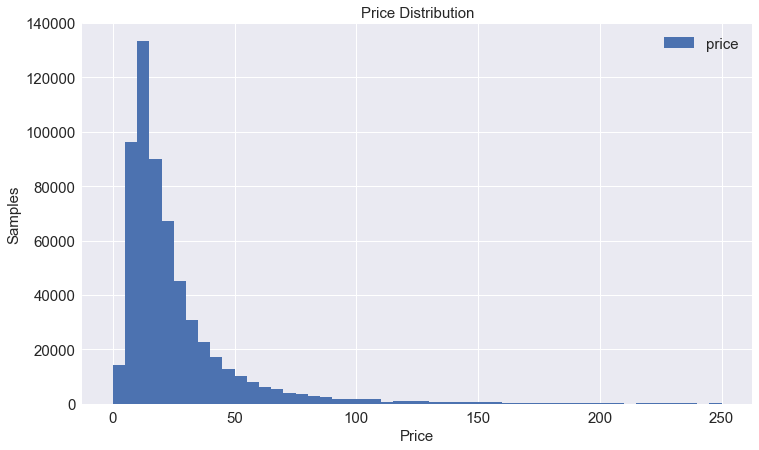

In [24]:
# визуализируем данные (какой лучший способ?)
plt.figure(figsize=(12, 7))
plt.hist(train['price'], bins=50, range=[0,250], label='price')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

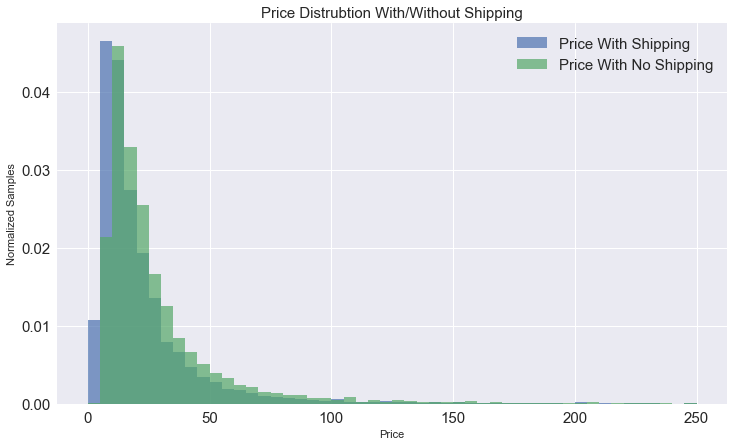

In [25]:
# сделаем разбивку по параметру (например доставка) и посмотрим распределение
# какой ещё параметр можно использовать?

shipping = train[train['shipping']==1]['price']
no_shipping = train[train['shipping']==0]['price']

plt.figure(figsize=(12,7))
plt.hist(shipping, bins=50, normed=True, range=[0,250], alpha=0.7, label='Price With Shipping')
plt.hist(no_shipping, bins=50, normed=True, range=[0,250], alpha=0.7, label='Price With No Shipping')
plt.title('Price Distrubtion With/Without Shipping', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Normalized Samples')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Анализ бренда товара
***

In [26]:
# Получим уникальные бренды
train['brand_name'].nunique()

3751

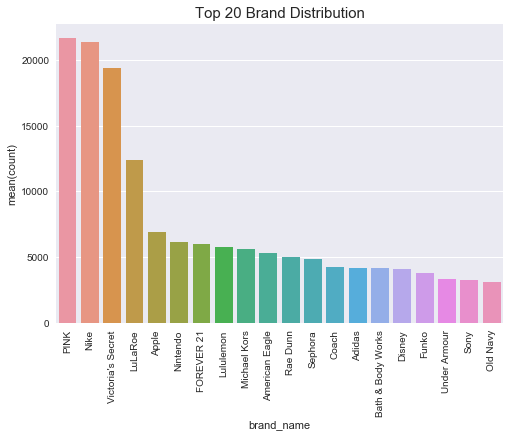

In [27]:
# Top 20
b20 = train['brand_name'].value_counts()[0:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

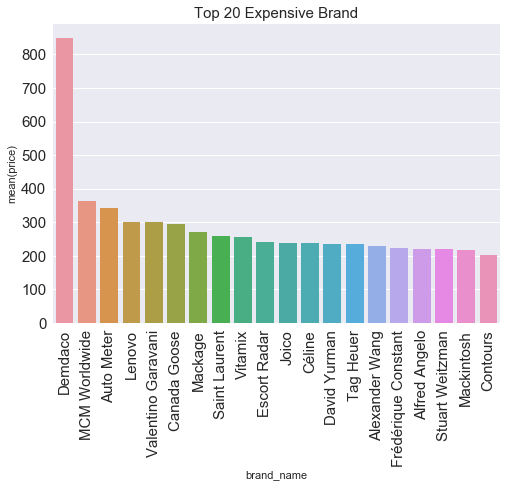

PINK                 0.063659
Nike                 0.062687
Victoria's Secret    0.056910
LuLaRoe              0.036462
Apple                0.020337
Nintendo             0.017958
FOREVER 21           0.017649
Lululemon            0.017047
Michael Kors         0.016415
American Eagle       0.015604
Rae Dunn             0.014676
Sephora              0.014303
Coach                0.012372
Adidas               0.012311
Bath & Body Works    0.012167
Disney               0.012014
Funko                0.011030
Under Armour         0.009807
Sony                 0.009587
Old Navy             0.009208
Hollister            0.008106
Carter's             0.007698
Urban Decay          0.007383
The North Face       0.007110
Too Faced            0.006828
Xbox                 0.006728
Independent          0.006711
MAC                  0.006514
Brandy Melville      0.006464
Kate Spade           0.006396
                       ...   
Sock It to Me        0.000003
Cocomo               0.000003
Onque Casu

In [28]:
# Сделаем обзор топ 20 и их стредюю цену
top20_brand = train.groupby('brand_name', axis=0).mean()
df_expPrice = pd.DataFrame(top20_brand.sort_values('price', ascending = False)['price'][0:20].reset_index())


ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top 20 Expensive Brand', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
train['brand_name'].value_counts(1)

# Обзор категорий товара
***

In [29]:
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

category_main        category_sub1       category_sub2  price
0           Men                 Tops            T-shirts   10.0
1   Electronics  Computers & Tablets  Components & Parts   52.0
2         Women       Tops & Blouses              Blouse   10.0
3          Home           Home Décor  Home Décor Accents   35.0
4         Women              Jewelry           Necklaces   44.0

## Основные категории

**Обзор интересов пользователей:**
- Товары относящиеся к категории Beauty в основном распределены для потребителей женщин (больше 56%)

++ Что её можно посмотреть?

**Генерация признаков товара на основе категорий и потреблений:**
- Можем мы определить потребителя товара и рабить категорию на пренадлежность к полу? (мужской, женский, универсальный товар)
- Будет ли это значемо для определеия цены?
- Можем ли создать признак по возрасту и разбить его на категории? 

In [ ]:
# Обзор основных категорий (что можно сказать по категории - электроника?)
train.groupby('category_main')['price'].describe()

In [31]:
# Посмотрим распределение
train['category_main'].value_counts(1)

Women                     0.451315
Beauty                    0.141427
Kids                      0.116116
Electronics               0.081456
Men                       0.063456
Home                      0.046394
Vintage & Collectibles    0.031697
Other                     0.030981
Handmade                  0.020806
Sports & Outdoors         0.016350
Name: category_main, dtype: float64

In [ ]:
plt.figure(figsize=(17,10))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items in Main Category', fontsize = 20)
plt.show()

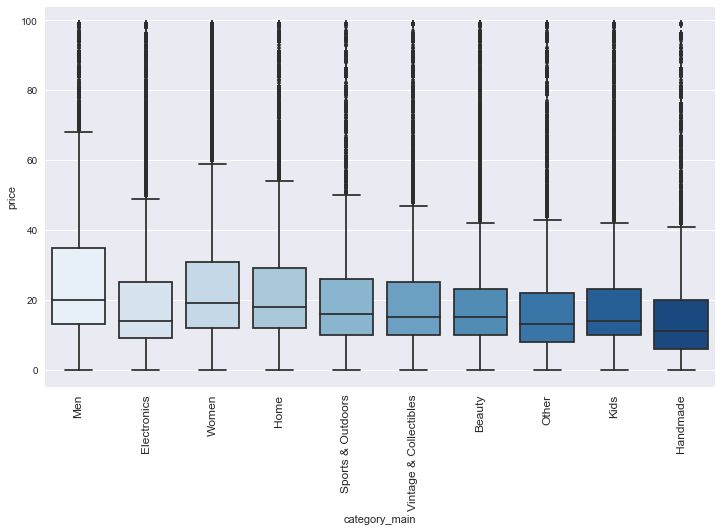

In [33]:
# какие есть способы визуализации, которые покажут:
# - где лежит основное кол-во данных?
# - как они распределены?
# - позволит уловить выбросы?
#main = pd.DataFrame(cat_train['category_main'].value_counts()).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
fig, axes = plt.subplots(figsize=(12, 7))
main = cat_train[cat_train["price"]<100]
# Use a color palette
ax = sns.boxplot( x=main["category_main"], y=main["price"], palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

sns.plt.show()

In [34]:
# Выделим товары не имющщие бренда
train['no_brand'] = train['brand_name'].isnull()

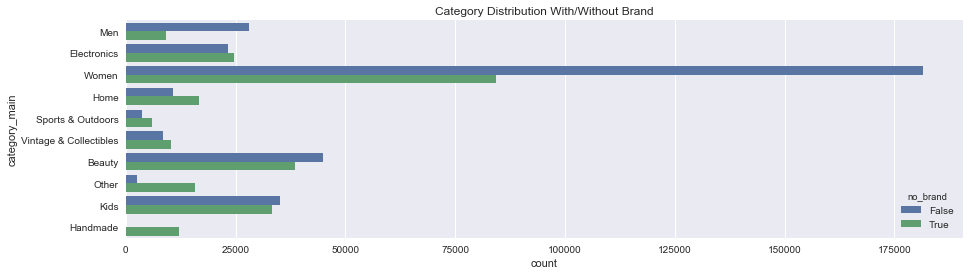

In [35]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='category_main', hue='no_brand', data=train).set_title('Category Distribution With/Without Brand');
plt.show()

## Распределение по подкатегориям 2


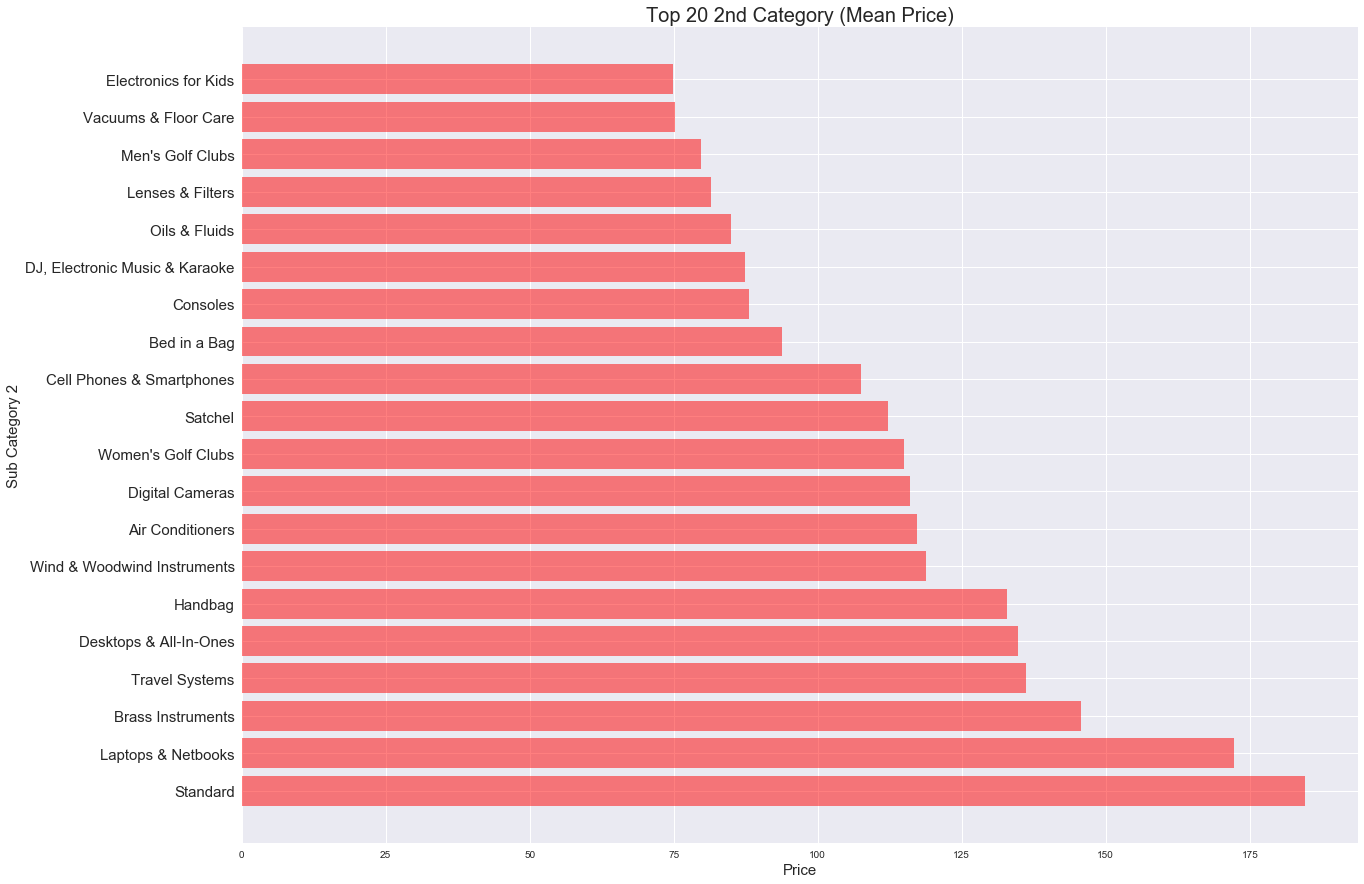

In [36]:
df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False).head(20)

plt.figure(figsize=(20, 15))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='r')
plt.yticks(range(0,len(df)), df['category_sub2'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 2', fontsize=15)
plt.title('Top 20 2nd Category (Mean Price)', fontsize=20)
plt.show()

## Распределение по подкатегориям 1

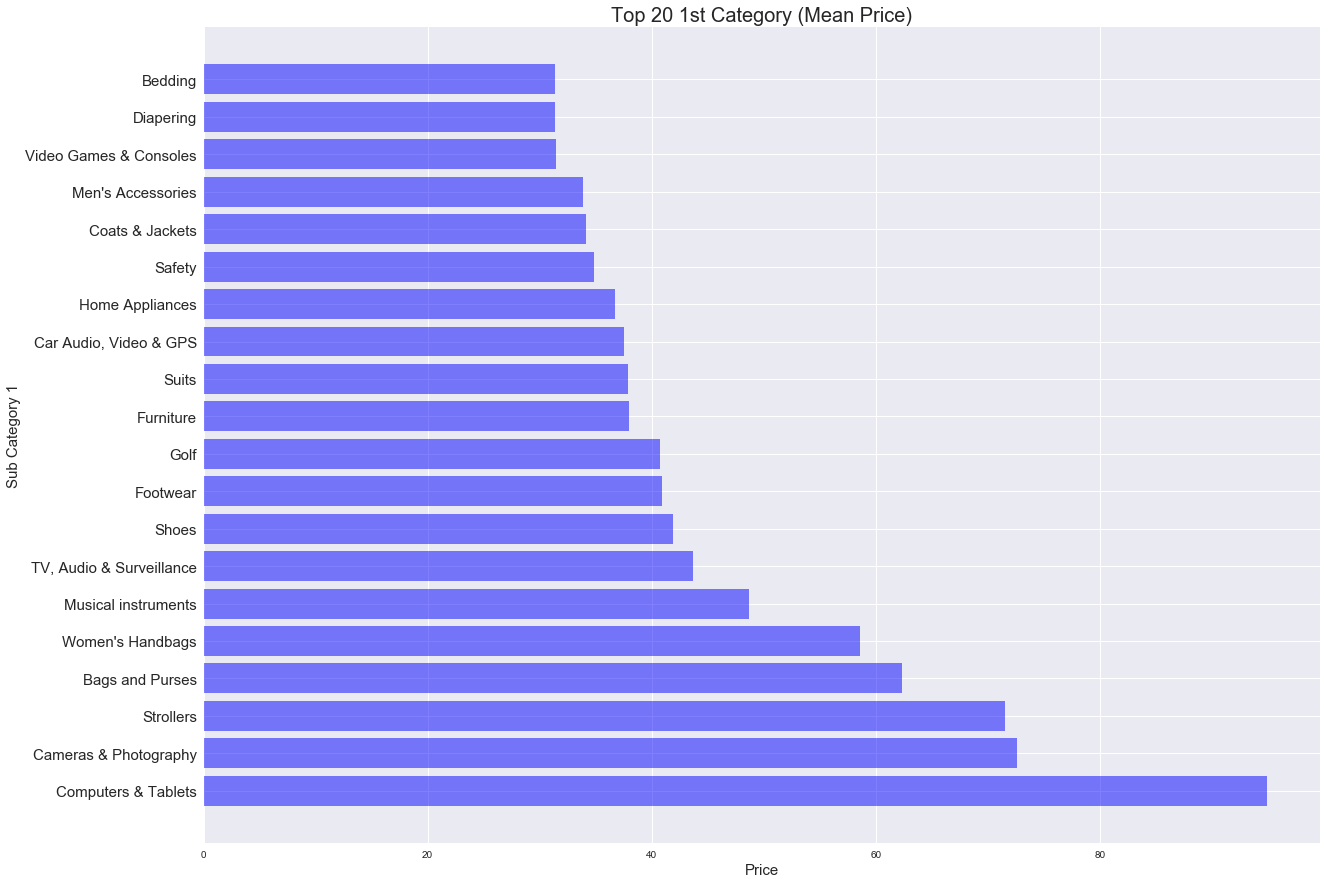

In [37]:
df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False)[0:20]

plt.figure(figsize=(20, 15))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='b')
plt.yticks(range(0,len(df)), df['category_sub1'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 1', fontsize=15)
plt.title('Top 20 1st Category (Mean Price)', fontsize=20)
plt.show()

## Анализ описания товара

**Гипотезы:** 
- Влияет ли качественное описние и его длина на цену товара?
- Точность описания влияет на цену товара?

++ Какие ещё можно выбрать гипотезы?

In [38]:
# Удаление пунктуации в описании
combined.item_description = combined.item_description.astype(str)

descr = combined[['item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))

descr['item_description'] = descr['item_description'].apply(remove_digits)
descr['item_description'] = descr['item_description'].apply(remove_punctuation)
descr['item_description'] = descr['item_description'].apply(remove_stop_words)
descr.head(3)

C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

item_description  price  count
0                                    description yet   10.0     18
1  keyboard great condition works like came box p...   52.0    188
2  adorable top hint lace key hole back pale pink...   10.0    124

In [39]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

descr['item_description'] = descr['item_description'].apply(porter.stem)

C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [40]:
descr.tail(10)

item_description  price  count
693349  â�—ï¸�listing â�—ï¸� brand new shades piu scar...    NaN     71
693350                 rm free shipping new highly addict    NaN     47
693351   purple boys polo shirt size  old navy never worn    NaN     59
693352  express deep olive green cardigan  ultra thin ...    NaN    121
693353                     shade medium neutral barley us    NaN     41
693354  flintquartz cluster self mined âœ¨measures xin...    NaN    243
693355  cosmetics travel bundle includes brow power un...    NaN    968
693356                      new free shipping basstop cas    NaN     31
693357  floral kimono tropical print open front hi low...    NaN     94
693358   floral scrub tops worn less  times brown belt ti    NaN     71

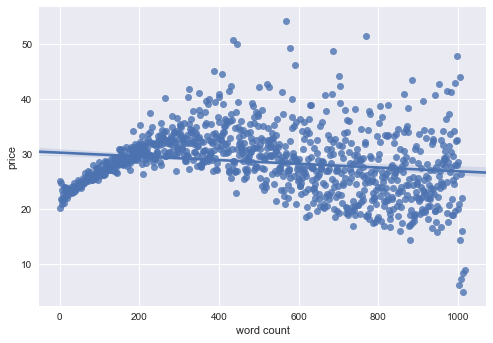

In [41]:
# сделаем визуализацию данных
# и посмотрим, как кол-во слов влияет на цену товара
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

# Препроцессинг обработки данных
***

In [42]:
combined.head()

brand_name                                      category_name  \
0        NaN                                  Men/Tops/T-shirts   
1      Razer  Electronics/Computers & Tablets/Components & P...   
2     Target                        Women/Tops & Blouses/Blouse   
3        NaN                 Home/Home Décor/Home Décor Accents   
4        NaN                            Women/Jewelry/Necklaces   

   item_condition_id                                   item_description  \
0                  3                                 No description yet   
1                  3  This keyboard is in great condition and works ...   
2                  1  Adorable top with a hint of lace and a key hol...   
3                  1  New with tags. Leather horses. Retail for [rm]...   
4                  1          Complete with certificate of authenticity   

                                  name  price  shipping  test_id  train_id  
0  MLB Cincinnati Reds T Shirt Size XL   10.0         1      NaN       0.0  
1     Razer BlackWidow Chroma Keyboard   52.0         0      NaN       1.0  
2                       AVA-VIV Blouse   10.0         1      NaN       2.0  
3                Leather Horse Statues   35.0         1      NaN       3.0  
4                 24K GOLD plated rose   44.0         0      NaN       4.0

In [43]:
# обработка пропусков
def handle_missing_values(df):
    df['category_name'].fillna(value='missing', inplace=True)
    df['brand_name'].fillna(value='None', inplace=True)
    df['item_description'].fillna(value='None', inplace=True)

In [44]:
# преобразование в категориальные данные
# - какое значение это имеет? На что может повлиять? Как отразиться на наборе данных?
def to_categorical(df):
    df['brand_name'] = df['brand_name'].astype('category')
    df['category_name'] = df['category_name'].astype('category')
    df['item_condition_id'] = df['item_condition_id'].astype('category')

In [ ]:
# какие ещё можно сделать категориальные преобразования?
# подходит ли предложенный способ для кодировки?

<img src='img/categorical.png'>

# Применение к данным
***

In [45]:
# применяем функции к набору
handle_missing_values(combined)
to_categorical(combined)

In [46]:
# 
handle_missing_values(combined_ML)
to_categorical(combined_ML)

In [47]:
# удаляем пунктуации
combined_ML.item_description = combined_ML.item_description.astype(str)

combined_ML['item_description'] = combined_ML['item_description'].apply(remove_digits)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_punctuation)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_stop_words)
combined_ML['item_description'] = combined_ML['item_description'].apply(to_lower)

combined_ML['name'] = combined_ML['name'].apply(remove_digits)
combined_ML['name'] = combined_ML['name'].apply(remove_punctuation)
combined_ML['name'] = combined_ML['name'].apply(remove_stop_words)
combined_ML['name'] = combined_ML['name'].apply(to_lower)

combined_ML.head(3)

brand_name                                   category_name  \
0      Rue21                               Women/Skirts/Maxi   
1       PINK                 Women/Tops & Blouses/Tank, Cami   
2    LuLaRoe  Women/Athletic Apparel/Pants, Tights, Leggings   

  item_condition_id                                   item_description  \
0                 2  wore big size small normally wear extra small ...   
1                 3               pink size xs racerback free shipping   
2                 1                                    description yet   

                          name  price  shipping   test_id  train_id  
0                   maxi skirt   22.0         0       NaN  538425.0  
1     vs pink dark maroon tank    NaN         1  366252.0       NaN  
2  lularoe xl irma tc leggings    NaN         0  311147.0       NaN

In [48]:
# 
combined.item_description = combined.item_description.astype(str)

combined['item_description'] = combined['item_description'].apply(remove_digits)
combined['item_description'] = combined['item_description'].apply(remove_punctuation)
combined['item_description'] = combined['item_description'].apply(remove_stop_words)
combined['item_description'] = combined['item_description'].apply(to_lower)

combined['name'] = combined['name'].apply(remove_digits)
combined['name'] = combined['name'].apply(remove_punctuation)
combined['name'] = combined['name'].apply(remove_stop_words)
combined['name'] = combined['name'].apply(to_lower)

# Генерация новых сущностей (фичей) на основе категорий (Main, Sub1, Sub2)
***

In [49]:
combined.isnull().any()

brand_name           False
category_name        False
item_condition_id    False
item_description     False
name                 False
price                 True
shipping             False
test_id               True
train_id              True
dtype: bool

In [50]:
combined.head()

brand_name                                      category_name  \
0       None                                  Men/Tops/T-shirts   
1      Razer  Electronics/Computers & Tablets/Components & P...   
2     Target                        Women/Tops & Blouses/Blouse   
3       None                 Home/Home Décor/Home Décor Accents   
4       None                            Women/Jewelry/Necklaces   

  item_condition_id                                   item_description  \
0                 3                                    description yet   
1                 3  keyboard great condition works like came box p...   
2                 1  adorable top hint lace key hole back pale pink...   
3                 1  new tags leather horses retail rm stand foot h...   
4                 1                  complete certificate authenticity   

                                name  price  shipping  test_id  train_id  
0  mlb cincinnati reds shirt size xl   10.0         1      NaN       0.0  
1   razer blackwidow chroma keyboard   52.0         0      NaN       1.0  
2                      avaviv blouse   10.0         1      NaN       2.0  
3              leather horse statues   35.0         1      NaN       3.0  
4                 k gold plated rose   44.0         0      NaN       4.0

In [51]:
combined_ML.head()

brand_name                                   category_name  \
0      Rue21                               Women/Skirts/Maxi   
1       PINK                 Women/Tops & Blouses/Tank, Cami   
2    LuLaRoe  Women/Athletic Apparel/Pants, Tights, Leggings   
3       None     Beauty/Hair Care/Shampoo & Conditioner Sets   
4    Sephora                              Beauty/Makeup/Face   

  item_condition_id                                   item_description  \
0                 2  wore big size small normally wear extra small ...   
1                 3               pink size xs racerback free shipping   
2                 1                                    description yet   
3                 1  silk express shampoo silk conditioner leave co...   
4                 1    deluxe samples ysl smashbox hourglass biossance   

                          name  price  shipping   test_id  train_id  
0                   maxi skirt   22.0         0       NaN  538425.0  
1     vs pink dark maroon tank    NaN         1  366252.0       NaN  
2  lularoe xl irma tc leggings    NaN         0  311147.0       NaN  
3   silk express hair products    NaN         0  280598.0       NaN  
4        bundle es everythings    NaN         1  216302.0       NaN

In [52]:
combined.head()

brand_name                                      category_name  \
0       None                                  Men/Tops/T-shirts   
1      Razer  Electronics/Computers & Tablets/Components & P...   
2     Target                        Women/Tops & Blouses/Blouse   
3       None                 Home/Home Décor/Home Décor Accents   
4       None                            Women/Jewelry/Necklaces   

  item_condition_id                                   item_description  \
0                 3                                    description yet   
1                 3  keyboard great condition works like came box p...   
2                 1  adorable top hint lace key hole back pale pink...   
3                 1  new tags leather horses retail rm stand foot h...   
4                 1                  complete certificate authenticity   

                                name  price  shipping  test_id  train_id  
0  mlb cincinnati reds shirt size xl   10.0         1      NaN       0.0  
1   razer blackwidow chroma keyboard   52.0         0      NaN       1.0  
2                      avaviv blouse   10.0         1      NaN       2.0  
3              leather horse statues   35.0         1      NaN       3.0  
4                 k gold plated rose   44.0         0      NaN       4.0

# Применяем CountVectorizer / TfidfVectorizer / LabelBinarizer
***

Для кодирования применяем: Pandas метод factorize и scikit-learn LabelEncoder. 
- результатом будет набор числовых данных в виде массива.

<img src='img/end-to-end-cats.svg'>

Кодируем каториальные данные в dummy/indicator (binary): в Pandas есть метод get_dummies и scikit-learn OneHotEncoder.
- количество уникальных категорий добавить такое же количество уникальных колонок!

<img src='img/ohe.png'>

# Создаем новые (разбиваем цену на 2 категории)

In [53]:
#bins = [0, 64, 5000]
#labels = ['less','more']
#combined['lt65'] = pd.cut(combined['price'], bins=bins, labels=labels)

combined.head()

brand_name                                      category_name  \
0       None                                  Men/Tops/T-shirts   
1      Razer  Electronics/Computers & Tablets/Components & P...   
2     Target                        Women/Tops & Blouses/Blouse   
3       None                 Home/Home Décor/Home Décor Accents   
4       None                            Women/Jewelry/Necklaces   

  item_condition_id                                   item_description  \
0                 3                                    description yet   
1                 3  keyboard great condition works like came box p...   
2                 1  adorable top hint lace key hole back pale pink...   
3                 1  new tags leather horses retail rm stand foot h...   
4                 1                  complete certificate authenticity   

                                name  price  shipping  test_id  train_id  
0  mlb cincinnati reds shirt size xl   10.0         1      NaN       0.0  
1   razer blackwidow chroma keyboard   52.0         0      NaN       1.0  
2                      avaviv blouse   10.0         1      NaN       2.0  
3              leather horse statues   35.0         1      NaN       3.0  
4                 k gold plated rose   44.0         0      NaN       4.0

In [54]:
# Применяем Vectorizer к "name" 
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(combined['name'])
X_name

<1286735x15973 sparse matrix of type '<class 'numpy.int64'>'
	with 4789374 stored elements in Compressed Sparse Row format>

In [55]:
# Применяем Vectorizer к "category_name"
cv = CountVectorizer()
X_category = cv.fit_transform(combined['category_name'])
#X_sub1 = cv.fit_transform(combined['sub_category_1'])
#X_sub2 = cv.fit_transform(combined['sub_category_2'])
X_category

<1286735x1007 sparse matrix of type '<class 'numpy.int64'>'
	with 5165431 stored elements in Compressed Sparse Row format>

In [56]:
# Применяем TFIDF к "item_description", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(combined['item_description'])

In [57]:
# Применяем LabelBinarizer к "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(combined['brand_name'])

# Создаем CSR_Matrix и соединяем с существующей 

### добавляем новые фичи к существовавшим
***

In [58]:
X_dummies = csr_matrix(pd.get_dummies(combined[['item_condition_id', 'shipping']], sparse=True).values)
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

# Разделяй, Обучай, Валидируй
***

In [59]:
# сделаем процесс train / test split
X_train_sparse = sparse_merge[:train_size]

X_test = sparse_merge[train_size:]

#X_train = sparse_merge[:len(combined_ML)]

#X_test = sparse_merge[len(combined_ML):]

In [60]:
combined.columns

Index(['brand_name', 'category_name', 'item_condition_id', 'item_description',
       'name', 'price', 'shipping', 'test_id', 'train_id'],
      dtype='object')

In [ ]:
# обусдим валидацию и варианты обучения

## Cross Validation

<img src="https://cdn-images-1.medium.com/max/948/1*4G__SV580CxFj78o9yUXuQ.png"/>

In [61]:
# разобьюем на части нашу выборку
from sklearn.cross_validation import KFold
eval_size = .10
kf = KFold(len(y), round(1. / eval_size))
train_indicies, valid_indicies = next(iter(kf))
X_train, y_train = X_train_sparse[train_indicies], y[train_indicies]
X_valid, y_valid = X_train_sparse[valid_indicies], y[valid_indicies]

C:\Users\Randy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## RMSLE функция

Почему не просто RMSE? В чем заключается смысл логорифмирования и как получить даныне обратно?


In [62]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

# GradientBoosting
## Обучаем LGBM

Почему LGBM, а не XgBoost / CatBoost?
Стоит попробовать CatBoost, так как много категориальных данных?


Приемущества LGBM "бустинга":
- скорость обучения (у LGBM) и большая эффективность
- не большие затраты память
- хорошая точность
- хорошая работа с большими наборами данных
- особенность деревьев

<img src='img/lgbm.png'>

In [63]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)

In [64]:
params = {}
#params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'

clf = lgb.train(params, d_train, 100)

In [65]:
#определяем цену
lgbm_pred=clf.predict(X_valid)

In [66]:
# трансформация цены в нормальную
np.expm1(lgbm_pred)

array([ 10.7214129 ,  29.60000413,  13.02518987, ...,  12.85446125,
        19.31981685,  15.34901857])

In [69]:
import time
start_time = time.time()
print('[{}] LGBM completed.'.format(time.time() - start_time))
print("LGBM rmsle: "+str(rmsle(np.expm1(y_valid), np.expm1(lgbm_pred))))

[0.0] LGBM completed.
LGBM rmsle: 0.540597319376


The RMSLE of LGBM is: **0.5406**

## Ridge Regression

In [70]:
import time 

start_time = time.time()

model = Ridge(solver = "sag", fit_intercept=False)

print("Fitting Ridge Model")
model.fit(X_train, y_train)

preds_valid = model.predict(X_valid)

print('[{}] Ridge completed.'.format(time.time() - start_time))
print("Ridge rmsle: "+str(rmsle(np.expm1(y_valid), np.expm1(preds_valid))))

Fitting Ridge Model
[32.998536586761475] Ridge completed.
Ridge rmsle: 0.482907420753


In [71]:
np.expm1(preds_valid)

array([  9.09673618,  83.84303118,  11.78868638, ...,  12.66779351,
        23.59042071,  11.21630299])

The RMSLE of Ridge Regression is: **0.4829**

# Что дальше?

1. Рассмотрим значимость "фич" и их отражение в таргите. Попробуем найти что-то интересно
2. Увеличить или уменьшить количество категорий.
3. Добавить больше анализа текста

++ Какие ещё варианты?

## Время Test

In [72]:
preds = model.predict(X_test)

t["price"] = np.expm1(preds)

C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [73]:
t

test_id       price
0             0   11.162749
1             1   12.555600
2             2   53.157534
3             3   17.925542
4             4    7.363347
5             5    9.959583
6             6    9.521093
7             7   33.185204
8             8   45.666661
9             9    6.283195
10           10   52.478731
11           11    9.582656
12           12   33.508056
13           13   49.353728
14           14   24.605690
15           15    8.701512
16           16   24.601817
17           17   17.042603
18           18   41.234336
19           19    7.499206
20           20    6.479075
21           21   10.071822
22           22   11.011129
23           23   13.974448
24           24   43.893530
25           25    7.502994
26           26   20.210556
27           27    8.181354
28           28   53.241879
29           29    7.257089
...         ...         ...
693329   693329   28.354434
693330   693330   20.699427
693331   693331   14.273625
693332   693332   43.814946
693333   693333   16.261933
693334   693334   81.738151
693335   693335    6.648241
693336   693336   15.763434
693337   693337   17.041259
693338   693338   14.168938
693339   693339   13.545883
693340   693340    3.973624
693341   693341  219.385862
693342   693342    4.910538
693343   693343   17.301045
693344   693344   21.939166
693345   693345   13.895224
693346   693346   29.366304
693347   693347   45.978350
693348   693348   67.798859
693349   693349   10.384145
693350   693350    8.716605
693351   693351    9.640998
693352   693352   14.098605
693353   693353   14.731720
693354   693354   19.804941
693355   693355   26.429490
693356   693356    6.252158
693357   693357   15.377224
693358   693358    9.742211

[693359 rows x 2 columns]

# Дискуссии и рефлексия
***

1. Это только мала часть анализа. Но как мы начинаем его делать, что означает "метод пирога"? 
2. Расскажите про TF IDF и способы генерации фич
3. Почему выбрана метрика с логорифмом
4. Какая особенность у бустинга, какой ещё следует попробовать?